# Movement Comparison

Find the average change in BTD value for each pixel, compare between FLC scene and non-FLC scene.

In [1]:
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import goes_grid_convert as ggc
import os
import pandas as pd
import fnmatch
import datetime

In [2]:
date = "20220914"

path = "/home/jturner/false_low_clouds_2023/Static_Features/estimation_data"

static_features_data = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

In [3]:
#---Gulf Stream
# region = "gulfstream"
# min_lon = -83
# min_lat = 26
# max_lon = -51
# max_lat = 50

#---Georges Bank
region = "georgesbank"
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [4]:
data_07 = xr.open_dataset('/home/jturner/false_low_clouds_2023/Static_Features/sample_data/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')

This sample subset is used later below. 

In [5]:
ds_07 = ggc.calc_latlon(data_07)

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

((x1,x2), (y1, y2)) = ggc.get_xy_from_latlon(ds_07, lats, lons)

subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

## Creating the BTD for each time step
* Takes a few minutes to run
* Only needed if dataset is not created within Static_Features/estimation_data

In [6]:
def create_BTD(static_features_data, filename):

    data_07 = xr.open_dataset(static_features_data+'/'+filename)
    
    year = filename[27:31]
    jul_day = filename[31:34]
    h = filename[34:36]
    m = filename[36:38]

    print('Processing 07 band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_07 = ggc.calc_latlon(data_07)

    ((x1,x2), (y1, y2)) = ggc.get_xy_from_latlon(ds_07, lats, lons)

    subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Search for corresponding Band 14 file:
    files = os.listdir(static_features_data) 
    pattern = 'OR_ABI-L1b-RadF-M6C14*'+filename[27:38]+'*.nc'
    filename_14 = str(fnmatch.filter(files, pattern)[0])

    data_14 = xr.open_dataset(static_features_data+'/'+filename_14)

    print('Processing 14 band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_14 = ggc.calc_latlon(data_14)

    ((x1,x2), (y1, y2)) = ggc.get_xy_from_latlon(ds_14, lats, lons)

    subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Calculate BTD and take product of the data over time
    T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
    T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

    BTD = T_14 - T_07
    
    yr_m_d = datetime.datetime.strptime(year+jul_day, '%Y%j').date()
    time_delta = datetime.timedelta(hours=int(h), minutes=int(m))
    dt = datetime.datetime.combine(yr_m_d, datetime.datetime.min.time()) + time_delta
    BTD = BTD.expand_dims({'time':[dt]})
    
    return BTD

In [7]:
#--- Accumulate xarrays in a list, then concatenate once at the end (faster)
datasets = []


#filenames = ['OR_ABI-L1b-RadF-M6C07_G16_s20221430310206_e20221430319526_c20221430319575.nc', 'OR_ABI-L1b-RadF-M6C14_G16_s20221430230206_e20221430239514_c20221430240000.nc', 'OR_ABI-L1b-RadF-M6C07_G16_s20221430040206_e20221430049525_c20221430049568.nc']
filenames = os.listdir(static_features_data)
for filename in filenames: 
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
        
        BTD = create_BTD(static_features_data, filename)
        datasets.append(BTD)

BTD_tot = xr.concat(datasets, dim='time')


Processing 07 band for 2022-257 00:20
Processing 14 band for 2022-257 00:20
Processing 07 band for 2022-257 01:40
Processing 14 band for 2022-257 01:40
Processing 07 band for 2022-257 02:40
Processing 14 band for 2022-257 02:40
Processing 07 band for 2022-257 02:00
Processing 14 band for 2022-257 02:00
Processing 07 band for 2022-257 03:40
Processing 14 band for 2022-257 03:40
Processing 07 band for 2022-257 00:30
Processing 14 band for 2022-257 00:30
Processing 07 band for 2022-257 01:10
Processing 14 band for 2022-257 01:10
Processing 07 band for 2022-257 02:10
Processing 14 band for 2022-257 02:10
Processing 07 band for 2022-257 03:10
Processing 14 band for 2022-257 03:10
Processing 07 band for 2022-257 03:30
Processing 14 band for 2022-257 03:30
Processing 07 band for 2022-257 00:00
Processing 14 band for 2022-257 00:00
Processing 07 band for 2022-257 00:10
Processing 14 band for 2022-257 00:10
Processing 07 band for 2022-257 01:50
Processing 14 band for 2022-257 01:50
Processing 0

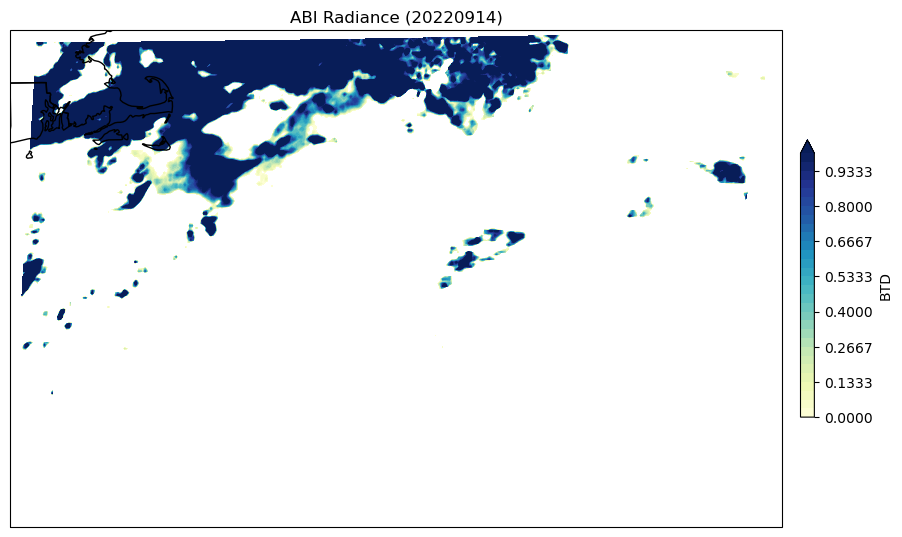

In [8]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 1, 31)

c=ax.contourf(BTD_tot[3].lon, BTD_tot[3].lat, BTD_tot[3], cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

Takes the difference between each pixel along the time step. Then the average of all the differences to find the total movement. False cloud events should show less movement. 

In [10]:
movement = []
dt = []

for i in range(len(BTD_tot.time)-1):
    BTD_diff = BTD_tot[i+1]-BTD_tot[i]
    mean_pixel_change = BTD_diff.mean(dim=['x', 'y']).values.item()
    movement.append(mean_pixel_change)
    dt.append(BTD_tot.time[i].values)

Text(0.5, 1.0, 'Movement per pixel (20220914)')

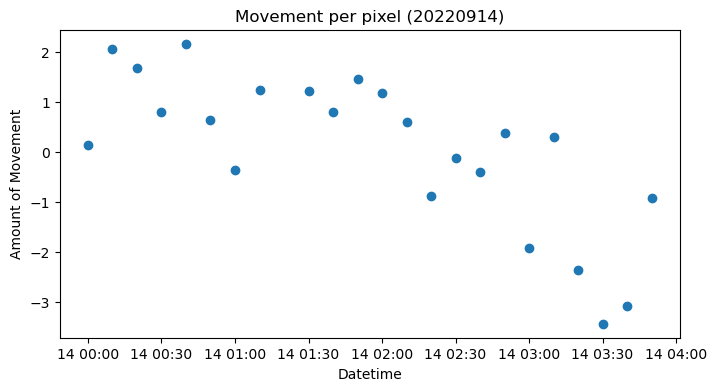

In [21]:
fig,ax = plt.subplots(1, figsize=(8, 4))

ax.scatter(dt, movement)
ax.set_xlabel('Datetime')
ax.set_ylabel('Amount of Movement')
ax.set_title('Movement per pixel ('+ date + ')')

### Movement comparison for non-FLC case

There are simply less clouds in this case, and therefore, less "movement" with the pixel-change method.

In [22]:
date2 = "20230427"
static_features_data2 = "/home/jturner/false_low_clouds_2023/Static_Features/"+date2

In [23]:
#--- Accumulate xarrays in a list, then concatenate once at the end (faster)
datasets = []


#filenames = ['OR_ABI-L1b-RadF-M6C07_G16_s20221430310206_e20221430319526_c20221430319575.nc', 'OR_ABI-L1b-RadF-M6C14_G16_s20221430230206_e20221430239514_c20221430240000.nc', 'OR_ABI-L1b-RadF-M6C07_G16_s20221430040206_e20221430049525_c20221430049568.nc']
filenames = os.listdir(static_features_data2)
for filename in filenames: 
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
        
        BTD = create_BTD(static_features_data2, filename)
        datasets.append(BTD)

BTD_tot2 = xr.concat(datasets, dim='time')

Processing 07 band for 2023-117 03:40
Processing 14 band for 2023-117 03:40
Processing 07 band for 2023-117 02:20
Processing 14 band for 2023-117 02:20
Processing 07 band for 2023-117 03:50
Processing 14 band for 2023-117 03:50
Processing 07 band for 2023-117 02:50
Processing 14 band for 2023-117 02:50
Processing 07 band for 2023-117 02:30
Processing 14 band for 2023-117 02:30
Processing 07 band for 2023-117 02:00
Processing 14 band for 2023-117 02:00
Processing 07 band for 2023-117 03:00
Processing 14 band for 2023-117 03:00
Processing 07 band for 2023-117 03:20
Processing 14 band for 2023-117 03:20
Processing 07 band for 2023-117 02:10
Processing 14 band for 2023-117 02:10
Processing 07 band for 2023-117 02:40
Processing 14 band for 2023-117 02:40
Processing 07 band for 2023-117 03:10
Processing 14 band for 2023-117 03:10
Processing 07 band for 2023-117 03:30
Processing 14 band for 2023-117 03:30


In [24]:
movement2 = []
dt2 = []

for i in range(len(BTD_tot2.time)-1):
    BTD_diff2 = BTD_tot2[i+1]-BTD_tot2[i]
    mean_pixel_change2 = BTD_diff2.mean(dim=['x', 'y']).values.item()
    movement2.append(mean_pixel_change2)
    dt2.append(BTD_tot2.time[i].values)


Text(0.5, 1.0, 'Movement per pixel (20230427)')

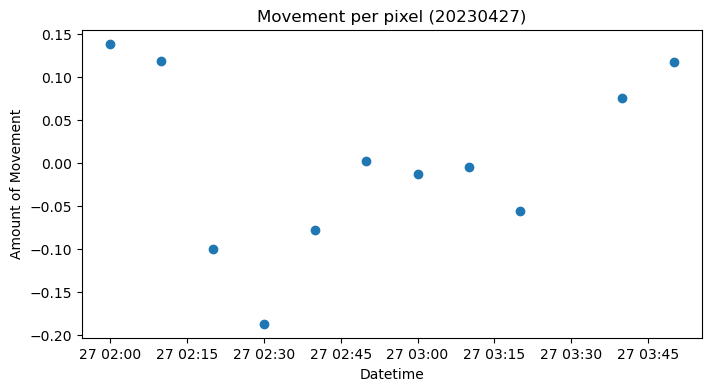

In [25]:
fig,ax = plt.subplots(1, figsize=(8, 4))

ax.scatter(dt2, movement2)
ax.set_xlabel('Datetime')
ax.set_ylabel('Amount of Movement')
ax.set_title('Movement per pixel ('+ date2 + ')')